#### Setup

In [1]:
from qiskit_transpiler import get_pm
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider
from qiskit_experiments.library import InterleavedRB
import qiskit.circuit.library as circuits
from qiskit import QuantumCircuit

In [2]:
#Setting the IBM provider
api_file = "../../../ibm_API_key"
with open(api_file, "r") as f:
        api_key = f.readline().strip()
provider = IBMProvider(api_key, instance='ibm-q-ncsu/nc-state/quantum-compiler')
backend = provider.get_backend('ibm_brisbane')

#### Circuit to only pass as a gate

In [3]:
gate_circuit = QuantumCircuit(2, name='custom_rzx')
gate_circuit.rzx(np.pi/2,0,1)
custom_rzx = gate_circuit.to_gate()

#### Circuit to pass for getting the calibration specific to the qubit

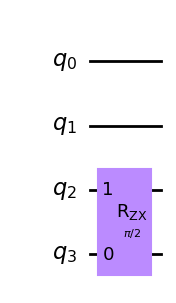

In [4]:
calibration_circuit = QuantumCircuit(4)
calibration_circuit.rzx(np.pi/2,3,2)
calibration_circuit.draw('mpl')

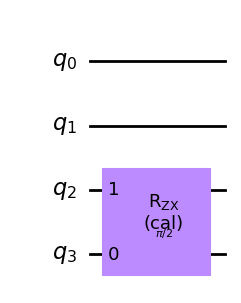

In [5]:
pm = get_pm(backend)
calibrated_circuit = pm.run(calibration_circuit)
calibrated_circuit.draw('mpl')

In [6]:
calibrated_circuit.calibrations

{'rzx': {((3, 2),
   (1.5707963267948966,)): ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=608, sigma=32, width=472.0, amp=0.11307690477071602, angle=1.7104583768606447), ControlChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=608, sigma=32, width=472.0, amp=0.0363447706333618, angle=-0.054933681946901736), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block1", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=120, sigma=30, beta=-0.5655548010054883, amp=0.15819124548400182, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=608, sigma=32, width=472.0, amp=0.11307690477071602, angle=-1.4311342767291486), ControlChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=608, sigma=32, width=472.0, amp=0.0363447706333618, angle=3.086658

In [7]:
calibration = list(calibrated_circuit.calibrations['rzx'].values())[0]
calibration

ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=608, sigma=32, width=472.0, amp=0.11307690477071602, angle=1.7104583768606447), ControlChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=608, sigma=32, width=472.0, amp=0.0363447706333618, angle=-0.054933681946901736), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block1", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=120, sigma=30, beta=-0.5655548010054883, amp=0.15819124548400182, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=608, sigma=32, width=472.0, amp=0.11307690477071602, angle=-1.4311342767291486), ControlChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=608, sigma=32, width=472.0, amp=0.0363447706333618, angle=3.0866589716428914), DriveChannel(2)), name="rescale_

In [8]:
backend.target.add_instruction(custom_rzx, {(3,2): InstructionProperties(calibration=calibration)})

In [9]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (3,2) # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rzx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

In [10]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

IBMBackendApiError: 'Error submitting job: "HTTPSConnectionPool(host=\'api.quantum.ibm.com\', port=443): Read timed out. (read timeout=900)"'

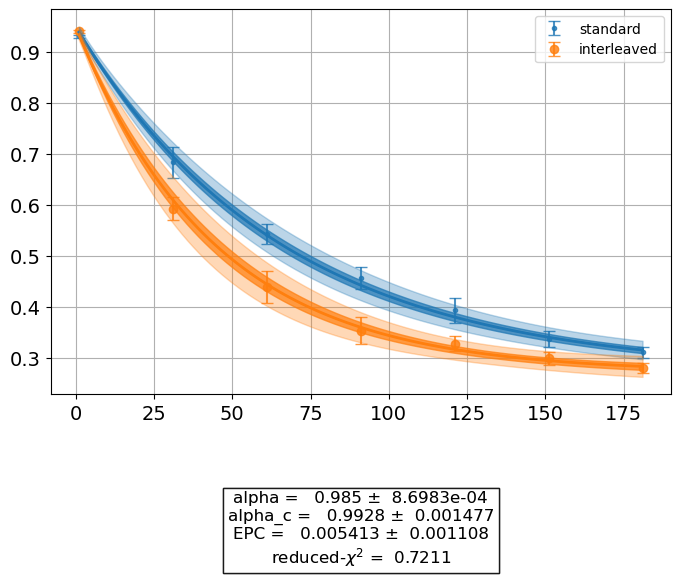

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 30
 - degree of freedom: 10
 - chi-square: 7.211476323892812
 - reduced chi-square: 0.7211476323892813
 - Akaike info crit.: -1.2873709415703072
 - Bayesian info crit.: 1.2688583768907264
 - init params:
  * a = 0.6950912985667295
  * alpha = 0.9867549020197885
  * b = 0.25
  * alpha_c = 0.9960465970250635
 - fit params:
  * a = 0.6756677312372917 ± 0.009304643405861889
  * alpha = 0.9849874273895272 ± 0.0008698299379620953
  * b = 0.2721877637463213 ± 0.009273890247250977
  * alpha_c = 0.9927826118180736 ± 0.0014766726191447403
 - correlations:
  * (a, b) = -0.9234711854613247
  * (alpha, b) = -0.7224063623413136
  * (b, alpha_c) = -0.4417980600070926
  * (alpha, alpha_c) = 0.05249249376676061
  * (a, alpha_c

In [ ]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

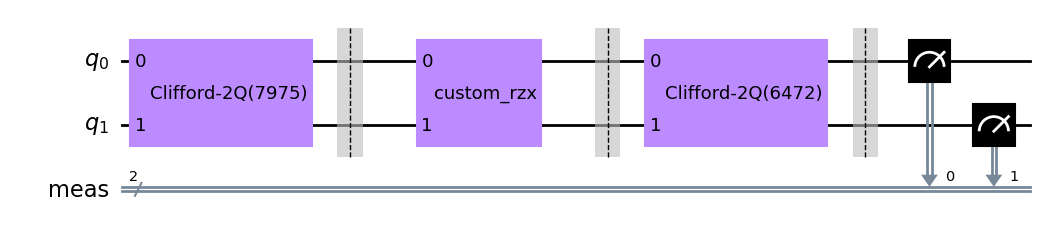

In [ ]:
int_exp.circuits()[1].draw(output='mpl')

In [ ]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')